# Preliminary trials to reduce dimensions of the image

In [ ]:
import torch
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
train_data0 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/data0.npy')
train_data1 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/data1.npy')
train_data2 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/data2.npy')

lab_data0 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/lab0.npy')
lab_data1 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/lab1.npy')
lab_data2 = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/lab2.npy')

# combine the data
train_data = np.concatenate((train_data0, train_data1, train_data2), axis=0)
lab_data = np.concatenate((lab_data0, lab_data1, lab_data2), axis=0)

print(train_data.shape)
print(lab_data.shape)

(30000, 40, 168)
(30000,)


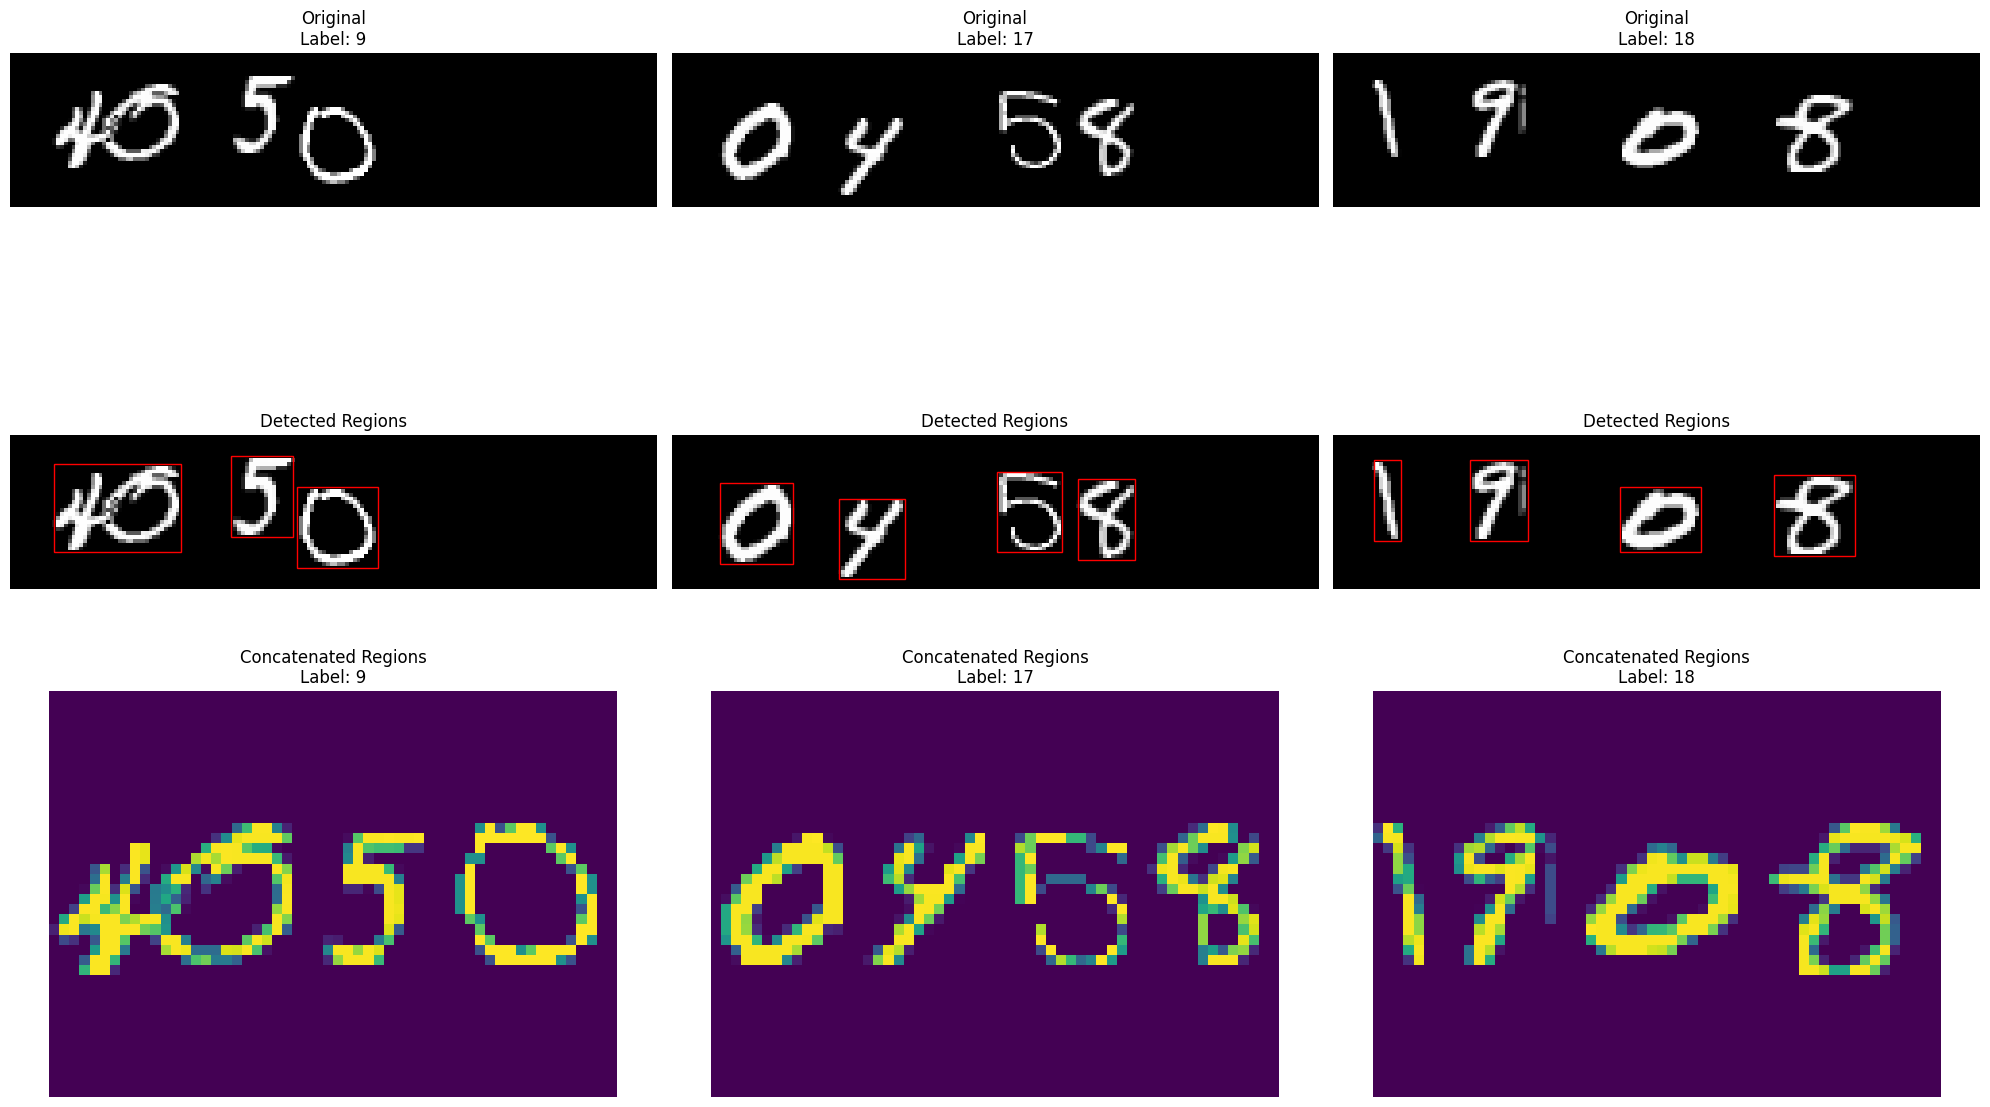

Original image size:  torch.Size([1, 40, 168])
Processed image size:  torch.Size([1, 40, 56])


In [3]:
def extract_digit_regions(image, threshold_factor=1.5, max_regions=4):  # Reduced threshold factor
    """Extract regions containing digits, limited to max_regions"""
    if torch.is_tensor(image):
        image = image.numpy()
    
    # Threshold the image
    threshold = np.mean(image) + threshold_factor*np.std(image)
    binary = (image > threshold).astype(float)
    
    # Apply morphological operations to connect nearby components
    kernel = np.ones((2,2), np.float32)  # Small kernel for dilation
    binary = ndimage.binary_dilation(binary, structure=kernel)
    
    # Optional: Close small gaps
    binary = ndimage.binary_closing(binary, structure=kernel)
    
    # Label connected components
    labeled, num_features = ndimage.label(binary)
    
    # Get bounding boxes for each region
    regions = []
    min_area = 20  # Add minimum area threshold to filter out noise
    
    for label in range(1, num_features + 1):
        # Get coordinates where this label appears
        y_coords, x_coords = np.where(labeled == label)
        
        # Get bounding box
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        y_min, y_max = np.min(y_coords), np.max(y_coords)
        
        area = (x_max - x_min + 1) * (y_max - y_min + 1)
        
        # Only add regions above minimum area
        if area >= min_area:
            regions.append({
                'x_min': x_min,
                'x_max': x_max,
                'y_min': y_min,
                'y_max': y_max,
                'width': x_max - x_min + 1,
                'height': y_max - y_min + 1,
                'area': area
            })
    
    # Sort regions by x_min coordinate
    regions.sort(key=lambda x: x['x_min'])
    
    # If we have more than max_regions, keep only the largest ones
    if len(regions) > max_regions:
        regions.sort(key=lambda x: x['area'], reverse=True)
        regions = regions[:max_regions]
        # Re-sort by x_min coordinate
        regions.sort(key=lambda x: x['x_min'])
    
    return regions, binary
    
def concatenate_digit_regions(image, regions, target_width=56, padding=2):
    """Concatenate digit regions with padding and fixed width"""
    if torch.is_tensor(image):
        image = image.numpy()
    
    if not regions:
        # Return empty image if no regions found
        return np.zeros((40, target_width))
    
    # Get maximum height of regions
    max_height = 40  # Fixed height as in original images
    
    # Create new image
    new_image = np.zeros((max_height, target_width))
    
    # Calculate total width including padding
    total_original_width = sum(r['width'] for r in regions)
    total_padding = padding * (len(regions) - 1)
    available_width = target_width - total_padding
    
    # Ensure minimum width per region
    min_width_per_region = 5  # Minimum width to ensure visibility
    total_min_width = min_width_per_region * len(regions)
    
    if available_width < total_min_width:
        # Reduce padding if necessary
        padding = max(1, (target_width - total_min_width) // (len(regions) - 1))
        available_width = target_width - padding * (len(regions) - 1)
    
    # Calculate scale factor
    scale = available_width / total_original_width
    
    # Current x position
    current_x = 0
    
    for region in regions:
        # Extract region
        region_img = image[region['y_min']:region['y_max']+1,
                         region['x_min']:region['x_max']+1]
        
        # Calculate scaled width for this region
        scaled_width = max(min_width_per_region, 
                         int(region['width'] * scale))
        
        # Resize the region
        if scaled_width != region_img.shape[1]:
            try:
                region_img = resize_region(region_img, scaled_width)
            except:
                # Fallback to minimum width if resize fails
                scaled_width = min_width_per_region
                region_img = resize_region(region_img, scaled_width)
        
        # Calculate vertical centering
        y_offset = (max_height - region_img.shape[0]) // 2
        
        # Ensure we don't exceed boundaries
        if current_x + scaled_width > target_width:
            scaled_width = target_width - current_x
            if scaled_width > 0:
                region_img = resize_region(region_img, scaled_width)
        
        if scaled_width > 0:  # Only proceed if we have valid width
            # Place region in new image
            new_image[y_offset:y_offset+region_img.shape[0],
                     current_x:current_x+scaled_width] = region_img
            current_x += scaled_width + padding
    
    return new_image

def resize_region(region_img, new_width):
    """Resize region while maintaining aspect ratio"""
    if new_width < 1:
        new_width = 1
    
    aspect_ratio = region_img.shape[1] / region_img.shape[0]
    new_height = min(40, int(new_width / aspect_ratio))
    
    # Ensure minimum height
    new_height = max(5, new_height)
    
    # Simple resize using nearest neighbor
    x_scale = new_width / region_img.shape[1]
    y_scale = new_height / region_img.shape[0]
    
    y_coords, x_coords = np.mgrid[:new_height, :new_width]
    y_coords = (y_coords / y_scale).astype(np.int32)
    x_coords = (x_coords / x_scale).astype(np.int32)
    
    y_coords = np.clip(y_coords, 0, region_img.shape[0] - 1)
    x_coords = np.clip(x_coords, 0, region_img.shape[1] - 1)
    
    return region_img[y_coords, x_coords]

class DigitSumDataset(Dataset):
    def __init__(self, images, labels, max_sum=36):  # Changed max_sum to 36
        self.images = torch.FloatTensor(images)
        self.images = self.images.reshape(-1, 1, 40, 168)
        
        # Store original images before transformation
        self.original_images = self.images.clone()
        
        # Process each image to extract digit regions
        processed_images = []
        self.regions_info = []
        
        for img in self.images[:, 0]:
            regions, binary = extract_digit_regions(img, max_regions=4)  # Set max_regions to 4
            concatenated = concatenate_digit_regions(img, regions)
            processed_images.append(concatenated)
            self.regions_info.append(regions)
        
        # Convert processed images to tensor
        processed_images = np.stack(processed_images)
        self.processed_images = torch.FloatTensor(processed_images).unsqueeze(1)
        
        # Apply transformations for model input
        self.model_input = self.processed_images.repeat(1, 3, 1, 1)
        self.model_input = (self.model_input - self.model_input.mean()) / self.model_input.std()
        
        self.labels = torch.clamp(torch.LongTensor(labels), 0, max_sum)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            'original': self.original_images[idx],
            'processed': self.processed_images[idx],
            'transformed': self.model_input[idx],
            'label': self.labels[idx],
            'regions': self.regions_info[idx]
        }

def visualize_processing(dataset, num_samples=3):
    """Visualize original, processed, and transformed images"""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # fig, axes = plt.subplots(4, num_samples, figsize=(20, 12))
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 12))
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        # Original image
        original = sample['original'][0].numpy()
        axes[0, i].imshow(original, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original\nLabel: {sample["label"].item()}')
        
        # Show regions on original
        axes[1, i].imshow(original, cmap='gray')
        axes[1, i].axis('off')
        for region in sample['regions']:
            rect = plt.Rectangle((region['x_min'], region['y_min']), 
                               region['width'], region['height'],
                               fill=False, edgecolor='red')
            axes[1, i].add_patch(rect)
        axes[1, i].set_title('Detected Regions')
        
        # Processed image (concatenated regions)
        processed = sample['processed'][0].numpy()
        axes[2, i].imshow(processed)
        axes[2, i].axis('off')
        axes[2, i].set_title(f'Concatenated Regions\nLabel: {sample["label"].item()}')

        # # Transformed image (model input)
        # transformed = sample['transformed'][0].numpy()
        # axes[3, i].imshow(transformed, cmap='gray')
        # axes[3, i].axis('off')
        # axes[3, i].set_title('Model Input\n(1st channel)')
        
        # # Print region information
        # print(f"\nSample {i} regions:")
        # for j, region in enumerate(sample['regions']):
        #     print(f"Digit {j+1}: x=[{region['x_min']}-{region['x_max']}], "
        #           f"width={region['width']}, height={region['height']}")
    
    plt.tight_layout()
    plt.show()

# Create dataset and visualize
dataset = DigitSumDataset(train_data, lab_data)
visualize_processing(dataset)

# print the size of the image before and after processing
print("Original image size: ", dataset[0]['original'].shape)
print("Processed image size: ", dataset[0]['processed'].shape)

# Applying the above step to the entire dataset and saving it

In [3]:
def preprocess_and_save_dataset(train_data, lab_data, save_path='preproc_data.npy'):
    """
    Preprocess the dataset and save it to a file
    
    Parameters:
    train_data: numpy array of training images
    lab_data: numpy array of labels
    save_path: path to save the preprocessed data
    """
    # Convert to float tensor and reshape
    images = torch.FloatTensor(train_data)
    images = images.reshape(-1, 1, 40, 168)
    
    # Process each image
    processed_images = []
    regions_info = []
    
    print("Processing images...")
    for i, img in enumerate(images[:, 0]):
        if i % 100 == 0:  # Progress indicator
            print(f"Processing image {i}/{len(images)}")
            
        # Extract and concatenate regions
        regions, binary = extract_digit_regions(img, max_regions=4)
        concatenated = concatenate_digit_regions(img, regions)
        processed_images.append(concatenated)
        regions_info.append(regions)
    
    # Stack processed images
    processed_images = np.stack(processed_images)
    
    # Create model input (3 channels, normalized)
    processed_tensor = torch.FloatTensor(processed_images).unsqueeze(1)
    model_input = processed_tensor.repeat(1, 3, 1, 1)
    model_input = (model_input - model_input.mean()) / model_input.std()
    
    # Convert labels
    labels = torch.clamp(torch.LongTensor(lab_data), 0, 36)
    
    # Save all preprocessed data
    save_dict = {
        'processed_images': processed_images,
        'model_input': model_input.numpy(),
        'labels': labels.numpy(),
        'regions_info': regions_info
    }
    
    print(f"Saving preprocessed data to {save_path}")
    np.save(save_path, save_dict, allow_pickle=True)
    print("Done!")
    
    return save_dict

class PreprocessedDigitDataset(Dataset):
    """Dataset class for preprocessed digit data"""
    def __init__(self, data_path='preproc_data.npy'):
        # Load preprocessed data
        data_dict = np.load(data_path, allow_pickle=True).item()
        
        self.processed_images = torch.FloatTensor(data_dict['processed_images']).unsqueeze(1)
        self.model_input = torch.FloatTensor(data_dict['model_input'])
        self.labels = torch.LongTensor(data_dict['labels'])
        self.regions_info = data_dict['regions_info']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'processed': self.processed_images[idx],
            'transformed': self.model_input[idx],
            'label': self.labels[idx],
            'regions': self.regions_info[idx]
        }

# Preprocessing and saving the dataset
preprocessed_data = preprocess_and_save_dataset(train_data, lab_data)

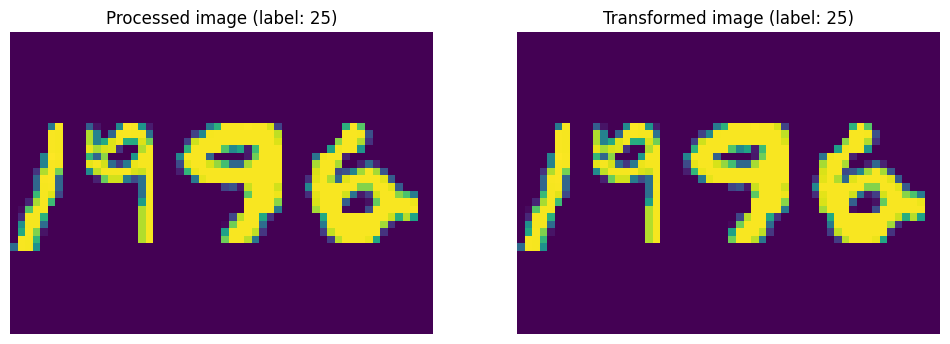

Regions: [{'x_min': 9, 'x_max': 16, 'y_min': 8, 'y_max': 28, 'width': 8, 'height': 21, 'area': 168}, {'x_min': 20, 'x_max': 31, 'y_min': 12, 'y_max': 32, 'width': 12, 'height': 21, 'area': 252}, {'x_min': 57, 'x_max': 74, 'y_min': 9, 'y_max': 29, 'width': 18, 'height': 21, 'area': 378}, {'x_min': 86, 'x_max': 104, 'y_min': 4, 'y_max': 24, 'width': 19, 'height': 21, 'area': 399}]


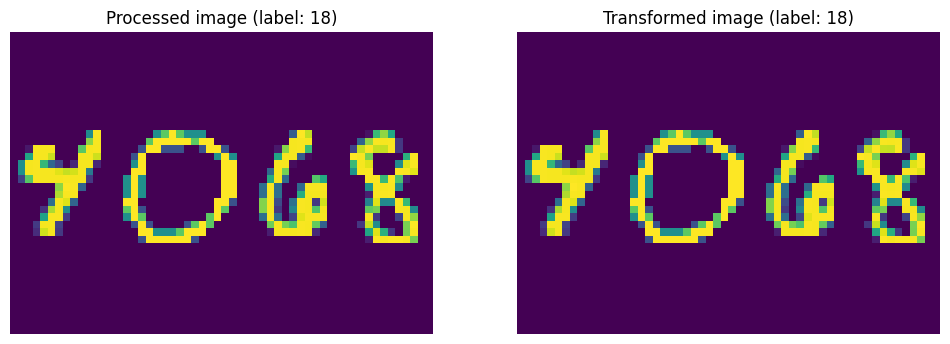

Regions: [{'x_min': 6, 'x_max': 21, 'y_min': 13, 'y_max': 33, 'width': 16, 'height': 21, 'area': 336}, {'x_min': 37, 'x_max': 57, 'y_min': 13, 'y_max': 33, 'width': 21, 'height': 21, 'area': 441}, {'x_min': 80, 'x_max': 93, 'y_min': 3, 'y_max': 23, 'width': 14, 'height': 21, 'area': 294}, {'x_min': 111, 'x_max': 123, 'y_min': 9, 'y_max': 29, 'width': 13, 'height': 21, 'area': 273}]


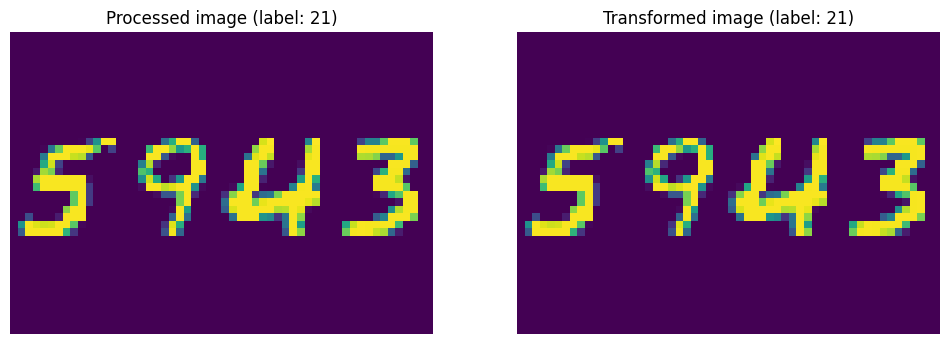

Regions: [{'x_min': 5, 'x_max': 24, 'y_min': 10, 'y_max': 30, 'width': 20, 'height': 21, 'area': 420}, {'x_min': 47, 'x_max': 61, 'y_min': 10, 'y_max': 30, 'width': 15, 'height': 21, 'area': 315}, {'x_min': 80, 'x_max': 98, 'y_min': 9, 'y_max': 29, 'width': 19, 'height': 21, 'area': 399}, {'x_min': 123, 'x_max': 138, 'y_min': 4, 'y_max': 24, 'width': 16, 'height': 21, 'area': 336}]


In [ ]:
# Load and use the preprocessed dataset:
dataset = PreprocessedDigitDataset('/data/gaurav.bhole/MLNS/DL_ass_data/preproc_data.npy')

def display_sample(sample):
    """Display a sample from the dataset"""
    processed = sample['processed'].squeeze()
    transformed = sample['transformed'].squeeze()
    label = sample['label']
    regions = sample['regions']
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(processed)
    plt.title(f"Processed image (label: {label})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(transformed[0])
    plt.title(f"Transformed image (label: {label})")
    plt.axis('off')

    plt.show()
    
    print(f"Regions: {regions}")

#  display a few samples
for i in range(3):
    display_sample(dataset[i])

## Imports

In [6]:
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import transforms, models
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

## Original Dataset

In [ ]:
# Load data
print("Loading data...")
data_path = '/data/gaurav.bhole/MLNS/DL_ass_data/'

data_files = {
    'data0': 'data0.npy',
    'data1': 'data1.npy',
    'data2': 'data2.npy',
    'lab0': 'lab0.npy',
    'lab1': 'lab1.npy',
    'lab2': 'lab2.npy'
}

loaded_data = {}
for name, filename in tqdm(data_files.items(), desc="Loading data files"):
    loaded_data[name] = np.load(data_path + filename)

print("\nCombining datasets...")
train_data = np.concatenate(
    (loaded_data['data0'], loaded_data['data1'], loaded_data['data2']), 
    axis=0
)
lab_data = np.concatenate(
    (loaded_data['lab0'], loaded_data['lab1'], loaded_data['lab2']), 
    axis=0
)

print(f"Final data shapes - Images: {train_data.shape}, Labels: {lab_data.shape}")

# split the data and save it as train and test
train_data, test_data, lab_data, test_lab = train_test_split(train_data, lab_data, test_size=0.2, random_state=42)
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/train_data.npy', train_data)
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/train_lab.npy', lab_data)
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/test_data.npy', test_data)
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/test_lab.npy', test_lab)

## Preprocessed Dataset

In [4]:
# Load the data
data_path = '/data/gaurav.bhole/MLNS/DL_ass_data/preproc_data.npy'
data_dict = np.load(data_path, allow_pickle=True).item()

# Calculate split point (80% for training)
total_samples = len(data_dict['model_input'])
train_size = int(0.8 * total_samples)

# Create training dictionary
train_dict = {
    'model_input': data_dict['model_input'][:train_size],
    'labels': data_dict['labels'][:train_size],
    'processed_images': data_dict['processed_images'][:train_size],
    'regions_info': data_dict['regions_info'][:train_size]
}

# Create test dictionary
test_dict = {
    'model_input': data_dict['model_input'][train_size:],
    'labels': data_dict['labels'][train_size:],
    'processed_images': data_dict['processed_images'][train_size:],
    'regions_info': data_dict['regions_info'][train_size:]
}

# Save the splits
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/preproc_train_data.npy', train_dict)
np.save('/data/gaurav.bhole/MLNS/DL_ass_data/preproc_test_data.npy', test_dict)

# Print shapes to verify
print("Training set sizes:")
print(f"model_input: {train_dict['model_input'].shape}")
print(f"labels: {train_dict['labels'].shape}")
print(f"processed_images: {train_dict['processed_images'].shape}")
print(f"regions_info: len = {len(train_dict['regions_info'])}")

print("\nTest set sizes:")
print(f"model_input: {test_dict['model_input'].shape}")
print(f"labels: {test_dict['labels'].shape}")
print(f"processed_images: {test_dict['processed_images'].shape}")
print(f"regions_info: len = {len(test_dict['regions_info'])}")

Training set sizes:
model_input: (24000, 3, 40, 56)
labels: (24000,)
processed_images: (24000, 40, 56)
regions_info: len = 24000

Test set sizes:
model_input: (6000, 3, 40, 56)
labels: (6000,)
processed_images: (6000, 40, 56)
regions_info: len = 6000


In [ ]:
# Load data
print("Loading data...")
data_path = '/data/gaurav.bhole/MLNS/DL_ass_data/preproc_data.npy'
data_dict = np.load(data_path, allow_pickle=True).item()
        
processed_images = torch.FloatTensor(data_dict['processed_images']).unsqueeze(1)
model_input = torch.FloatTensor(data_dict['model_input'])
labels = torch.LongTensor(data_dict['labels'])
regions_info = data_dict['regions_info']

loaded_data = {}
for name, filename in data_dict.items():
    loaded_data[name] = filename

# Load data
train_data = loaded_data['model_input']
lab_data = loaded_data['labels']

print(f"Final data shapes - Images: {train_data.shape}, Labels: {lab_data.shape}")

## Dataset Class

In [4]:
# Dataset class
class DigitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.FloatTensor(images).reshape(-1, 1, 40, 168)
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

## Augmentation

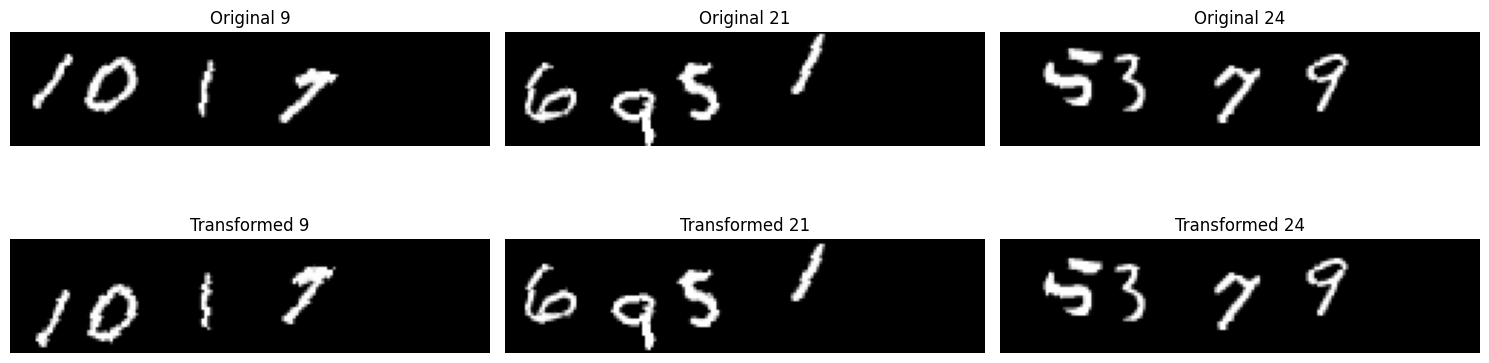

Image shape: torch.Size([1, 40, 168])


In [5]:
# Data preparation
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomRotation(degrees=10),
])

#  show sample images with and without transformations
train_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/train_data.npy', allow_pickle=True)
lab_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/train_lab.npy', allow_pickle=True)
dataset = DigitDataset(train_data, lab_data, transform=transform)
sample_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get a batch of images
images, labels = next(iter(sample_loader))

# Create a figure to display original and transformed images
plt.figure(figsize=(15, 5))

for i in range(3):  # Display 3 images
    # Original image
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i][0].numpy(), cmap='gray')
    plt.title(f'Original {labels[i].item()}')
    plt.axis('off')
    
    # Create a separate transform for displaying purposes (without normalization)
    display_transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.RandomRotation(degrees=10),
    ])
    
    # Transform the image
    transformed_image = display_transform(images[i])
    
    # Display transformed image
    plt.subplot(2, 3, i+4)
    plt.imshow(transformed_image[0].numpy(), cmap='gray')
    plt.title(f'Transformed {labels[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display statistics about the transformations
print("Image shape:", images[0].shape)

## Model

In [5]:
# ResNet18 based model
class ResNetModel(nn.Module):
    def __init__(self, num_classes=37):
        super(ResNetModel, self).__init__()
        # Load pretrained ResNet18
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify first conv layer to accept single channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final FC layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# PyTorch Lightning wrapper
class LitResNetModel(pl.LightningModule):
    def __init__(self, num_classes=37):
        super().__init__()
        self.save_hyperparameters()
        self.model = ResNetModel(num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        
        # Lists to store metrics per epoch
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.train_acc_epoch = []
        self.val_acc_epoch = []
        self.test_predictions = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
    
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        
        # Store predictions and labels for confusion matrix
        self.test_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=5e-4,  # Fixed learning rate
            weight_decay=5e-2  # Fixed weight decay
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

    def on_train_epoch_end(self):
        # Get the metrics logged for this epoch
        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_losses_epoch.append(train_loss.item())
        self.train_acc_epoch.append(train_acc.item())

    def on_validation_epoch_end(self):
        if "val_loss" in self.trainer.callback_metrics:
            val_loss = self.trainer.callback_metrics["val_loss"]
            val_acc = self.trainer.callback_metrics["val_acc"]
            self.val_losses_epoch.append(val_loss.item())
            self.val_acc_epoch.append(val_acc.item())

    def on_train_end(self):
        # Plot loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses_epoch, label='Training Loss')
        plt.plot(self.val_losses_epoch, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves')
        plt.legend()
        plt.savefig('loss_curves.png')
        plt.close()
        
        # Plot accuracy curves
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_acc_epoch, label='Training Accuracy')
        plt.plot(self.val_acc_epoch, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy Curves')
        plt.legend()
        plt.savefig('accuracy_curves.png')
        plt.close()

    def on_test_end(self):
        cm = confusion_matrix(self.test_labels, self.test_predictions)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        plt.close()

## Main

In [6]:
# Set medium precision
torch.set_float32_matmul_precision('medium')

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

train_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/train_data.npy', allow_pickle=True)
lab_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/train_lab.npy', allow_pickle=True)
test_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/test_data.npy', allow_pickle=True)
lab_test_data = np.load('/data/gaurav.bhole/MLNS/DL_ass_data/test_lab.npy', allow_pickle=True)

dataset = DigitDataset(train_data, lab_data, transform=transform)
test_dataset = DigitDataset(test_data, lab_test_data)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training data shapes - Images: {train_data.shape}, Labels: {lab_data.shape}")
print(f"Testing data shapes - Images: {test_data.shape}, Labels: {lab_test_data.shape}")

# Data loaders
batch_size = 256  # Fixed batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Model training
model = LitResNetModel()
logger = TensorBoardLogger("logs", name="resnet_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/data/gaurav.bhole/MLNS/final_train_orig",
    filename="resnet_model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    precision='16-mixed',
    max_epochs=100,
    # devices='auto',
    devices=1,
    logger=logger,
    # strategy='ddp' if torch.cuda.device_count() > 1 else None,
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=5)],
    log_every_n_steps=10,
)

# # Train the model
trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training data shapes - Images: (24000, 40, 168), Labels: (24000,)
Testing data shapes - Images: (6000, 40, 168), Labels: (6000,)


/home/gourav/miniforge3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /data/gaurav.bhole/MLNS/final_train_orig exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNetModel      | 11.2 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.757    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 85/85 [00:03<00:00, 23.97it/s, v_num=6, val_loss=0.459, val_acc=0.870, train_loss=0.0591, train_acc=0.990]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 85/85 [00:03<00:00, 23.93it/s, v_num=6, val_loss=0.459, val_acc=0.870, train_loss=0.0591, train_acc=0.990]


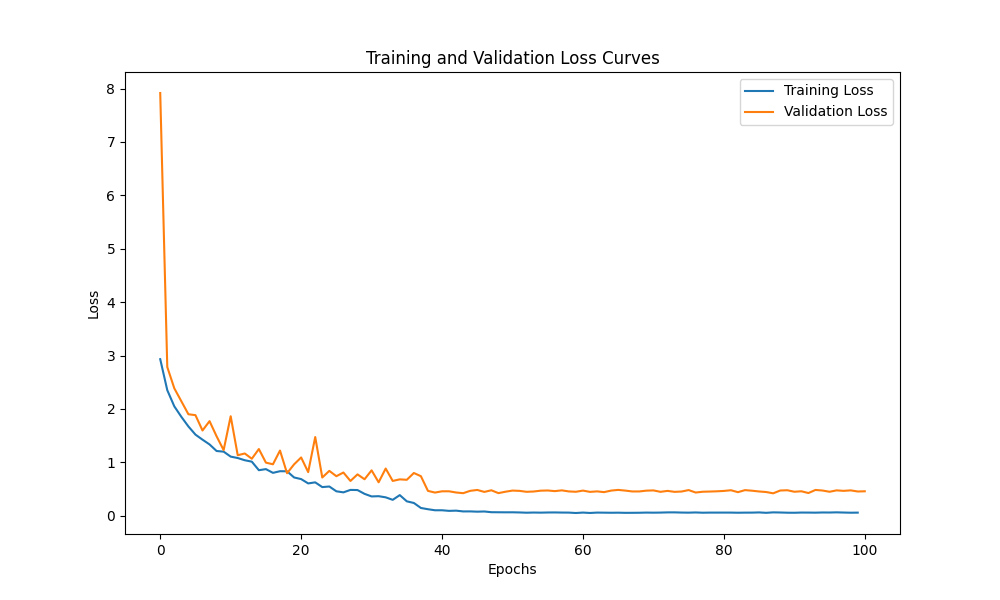

In [7]:
# display the plots
from IPython.display import Image
Image(filename='loss_curves.png')

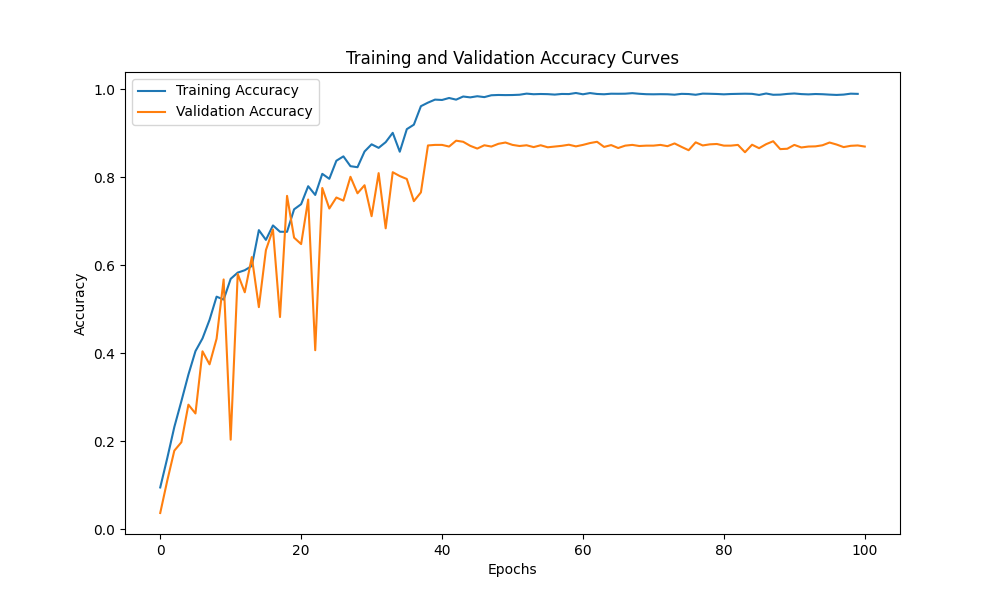

In [8]:
Image(filename='accuracy_curves.png')